# Bagian Baru

In [2]:
%pip install opencv-python-headless
%pip install numpy
%pip install matplotlib
%pip install tensorflow
%pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from collections import Counter


2024-07-08 09:51:16.873240: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 09:51:16.875891: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 09:51:16.884649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 09:51:16.901473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 09:51:16.901511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 09:51:16.913212: I tensorflow/core/platform/cpu_feature_guard.cc:

In [4]:
# Path to your dataset directory
dataset_dir = 'arya3'

In [5]:
# Fungsi untuk memuat gambar dan anotasi
def load_dataset(dataset_dir):
    images = []
    annotations = []
    classes_set = set()

    # Memuat gambar dan anotasi XML yang sesuai
    image_dir = os.path.join(dataset_dir, 'images')
    label_dir = os.path.join(dataset_dir, 'labels')

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            annotation_path = os.path.join(label_dir, os.path.splitext(filename)[0] + '.xml')

            # Membaca gambar
            image = cv2.imread(img_path)
            height, width, _ = image.shape

            # parsing anotasi XML
            tree = ET.parse(annotation_path)
            root = tree.getroot()

            # Mengambil ukuran gambar dari XML
            image_size = root.find('size')
            img_width = int(image_size.find('width').text)
            img_height = int(image_size.find('height').text)

            # Mengubah ukuran gambar jika diperlukan (opsional)
            #image = cv2.resize(image, (320, 320))

            # Mengambil koordinat bounding box dan label
            for obj in root.findall('object'):
                obj_name = obj.find('name').text
                classes_set.add(obj_name)  # Menambahkan kelas ke set kelas
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text) / img_width * 320
                xmax = int(bbox.find('xmax').text) / img_width * 320
                ymin = int(bbox.find('ymin').text) / img_height * 320
                ymax = int(bbox.find('ymax').text) / img_height * 320

                annotations.append({
                    'image_path': img_path,
                    'label': obj_name,
                    'bbox': [xmin, ymin, xmax, ymax],
                })

            images.append(image)

    classes_list = sorted(list(classes_set))  # Mengubah set menjadi daftar kelas yang terurut
    num_classes = len(classes_list)

    return images, annotations, num_classes, classes_list

In [6]:
# Fungsi untuk menampilkan gambar dengan bounding box
def display_images_with_bboxes(images, annotations, classes_list, num_samples=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        image = images[i]
        ann = annotations[i]
        bbox = ann['bbox']
        label = ann['label']
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.title(classes_list[label])
    plt.show()

In [7]:
# Memuat dataset
images, annotations, num_classes, classes_list = load_dataset(dataset_dir)


In [8]:
# Mengubah label menjadi nilai numerik
class_to_index = {cls: idx for idx, cls in enumerate(classes_list)}
for annotation in annotations:
    annotation['label'] = class_to_index[annotation['label']]

In [9]:
# Menghitung jumlah setiap kelas dalam dataset
label_counts = Counter([ann['label'] for ann in annotations])

# Menampilkan statistik jumlah dataset berdasarkan kelas
print("\nStatistik jumlah dataset berdasarkan kelas:")
for cls, count in label_counts.items():
    print(f"{classes_list[cls]}: {count} gambar")


Statistik jumlah dataset berdasarkan kelas:
Sedih: 160 gambar
Marah: 160 gambar
Senang: 161 gambar
Takut: 160 gambar
Netral: 160 gambar


In [10]:
# Mempersiapkan data untuk pelatihan
X = np.array(images)
y_bbox = np.array([ann['bbox'] for ann in annotations])
y_class = np.array([ann['label'] for ann in annotations])

In [11]:
print(f"Length of X: {len(X)}")
print(f"Length of y_bbox: {len(y_bbox)}")
print(f"Length of y_class: {len(y_class)}")
print(f"Length of annotations: {len(annotations)}")

Length of X: 800
Length of y_bbox: 801
Length of y_class: 801
Length of annotations: 801


In [12]:
min_length = min(len(X), len(y_bbox), len(y_class), len(annotations))

X = X[:min_length]
y_bbox = y_bbox[:min_length]
y_class = y_class[:min_length]
annotations = annotations[:min_length]

In [13]:
# Membagi data menjadi set pelatihan dan validasi
X_train, X_val, y_bbox_train, y_bbox_val, y_class_train, y_class_val, annotations_train, annotations_val = train_test_split(
    X, y_bbox, y_class, annotations, test_size=0.2, random_state=42)

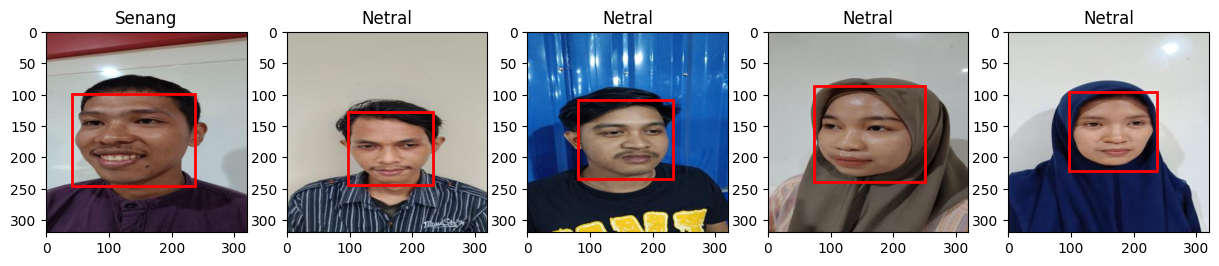

In [14]:
# Menampilkan beberapa gambar dengan bounding box
display_images_with_bboxes(X_train, annotations_train, classes_list, num_samples=5)

In [15]:
# Menampilkan informasi dataset
print(f"Jumlah gambar: {len(X)}")
print(f"Jumlah kelas: {num_classes}")
print(f"Dimensi gambar: {X.shape[1:]}")
print(f"Label kelas: {classes_list}")


Jumlah gambar: 800
Jumlah kelas: 5
Dimensi gambar: (320, 320, 3)
Label kelas: ['Marah', 'Netral', 'Sedih', 'Senang', 'Takut']


In [16]:
# Mendefinisikan model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(320, 320, 3))


/tmp/ipykernel_80700/3508476808.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(320, 320, 3))


In [17]:
# Menambahkan layer custom untuk regresi bounding box dan prediksi kelas
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [18]:
from tensorflow.keras.layers import Dropout

#Menambahkan Dropout ke layer yang sesuai
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Contoh: dropout 50%

In [19]:
# Output untuk regresi bounding box
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)


In [20]:
# Output untuk prediksi kelas
class_output = Dense(num_classes, activation='softmax', name='class_output')(x)


In [21]:
# Menggabungkan output
model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

In [22]:
# Menampilkan bentuk model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 160, 160,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 160, 160,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 160, 160,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 160, 160,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 160, 160,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 160, 160,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 160, 160,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 160, 160,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 160, 160,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 161, 161,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 80, 80,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 80, 80,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 80, 80,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 80, 80,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 80, 80,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 80, 80,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,238,089 (12.35 MB)

 Trainable params: 3,216,201 (12.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [23]:
# Mengompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'bbox_output': 'mean_squared_error', 'class_output': 'sparse_categorical_crossentropy'},
              metrics={'bbox_output': 'mse', 'class_output': 'accuracy'})

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Create a directory for checkpoints if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

# Update the checkpoint path to a local directory
checkpoint_path = 'checkpoints/model_checkpoint2.keras'

# Callback to save the model when val_accuracy improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_class_output_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq='epoch'
)

# Train the model with ModelCheckpoint
history = model.fit(
    X_train, {'bbox_output': y_bbox_train, 'class_output': y_class_train},
    validation_data=(X_val, {'bbox_output': y_bbox_val, 'class_output': y_class_val}),
    epochs=50,
    callbacks=[checkpoint]  # Add ModelCheckpoint callback
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bbox_output_mse: 31672.3086 - class_output_accuracy: 0.2155 - loss: 31674.2500
Epoch 1: val_class_output_accuracy improved from -inf to 0.18750, saving model to checkpoints/model_checkpoint2.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - bbox_output_mse: 31563.7148 - class_output_accuracy: 0.2152 - loss: 31565.6523 - val_bbox_output_mse: 29517.7812 - val_class_output_accuracy: 0.1875 - val_loss: 29525.2227
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bbox_output_mse: 24206.4590 - class_output_accuracy: 0.1645 - loss: 24208.3359
Epoch 2: val_class_output_accuracy improved from 0.18750 to 0.21250, saving model to checkpoints/model_checkpoint2.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - bbox_output_mse: 24141.6250 - class_output_accuracy: 0.1651 - loss: 24143.5020 - val_bbox_output_mse: 23693.4648 - val_class_output_accuracy: 0.2125 - val_loss: 23698.8574
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - bbox_output_mse: 18948.0

In [27]:
# Save the trained model
import os

# Create a directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained model in the 'models' directory
model.save('models/CNN_Arya2.keras')

In [28]:
import json
import os

# Simpan classes_list ke dalam file JSON di direktori lokal
def save_classes_list(classes_list, save_path):
    with open(save_path, 'w') as f:
        json.dump(classes_list, f)
    print(f"File JSON berhasil disimpan di: {save_path}")

# Contoh penggunaan:
# Ganti path sesuai dengan direktori lokal yang Anda inginkan
save_path = 'classes_list.json'
save_classes_list(classes_list, save_path)

# Jika ingin menyimpan di subdirektori, misalnya 'data'
os.makedirs('data', exist_ok=True)
save_path = 'data/classes_list.json'
save_classes_list(classes_list, save_path)

File JSON berhasil disimpan di: classes_list.json
File JSON berhasil disimpan di: data/classes_list.json


In [29]:
import pickle
import os

# Daftar kelas yang digunakan selama pelatihan
classes_list = [...]  # Daftar kelas yang sama dengan yang digunakan saat pelatihan

# Simpan daftar kelas ke file PKL di direktori lokal

os.makedirs('data', exist_ok=True)
with open('data/classes_list.pkl', 'wb') as f:
    pickle.dump(classes_list, f)
print("File PKL berhasil disimpan di: data/classes_list.pkl")

File PKL berhasil disimpan di: data/classes_list.pkl


In [ ]:
classes_list

In [30]:
import json

# Muat daftar kelas dari file JSON di direktori lokal


with open('data/classes_list.json', 'r') as f:
    classes_list = json.load(f)

print(classes_list)

['Marah', 'Netral', 'Sedih', 'Senang', 'Takut']


In [32]:
print(history.history.keys())

dict_keys(['bbox_output_mse', 'class_output_accuracy', 'loss', 'val_bbox_output_mse', 'val_class_output_accuracy', 'val_loss'])


dict_keys(['bbox_output_mse', 'class_output_accuracy', 'loss', 'val_bbox_output_mse', 'val_class_output_accuracy', 'val_loss'])
Bounding Box Loss keys not found in history.


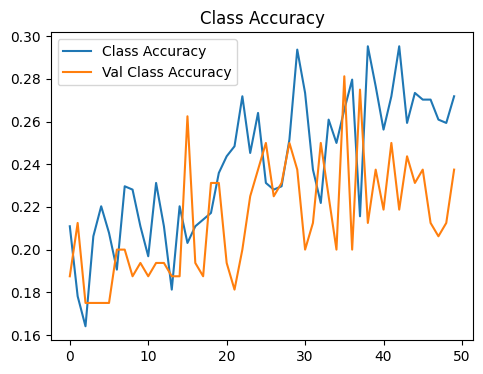

In [33]:
import matplotlib.pyplot as plt

# Print available keys to debug
print(history.history.keys())

# Adjust the plotting based on available keys
plt.figure(figsize=(12, 4))

# Plot Bounding Box Loss if available
if 'bbox_output_loss' in history.history and 'val_bbox_output_loss' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['bbox_output_loss'], label='Bounding Box Loss')
    plt.plot(history.history['val_bbox_output_loss'], label='Val Bounding Box Loss')
    plt.legend()
    plt.title('Bounding Box Loss')
else:
    print("Bounding Box Loss keys not found in history.")

# Plot Class Accuracy if available
if 'class_output_accuracy' in history.history and 'val_class_output_accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'], label='Class Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Val Class Accuracy')
    plt.legend()
    plt.title('Class Accuracy')
else:
    print("Class Accuracy keys not found in history.")

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step


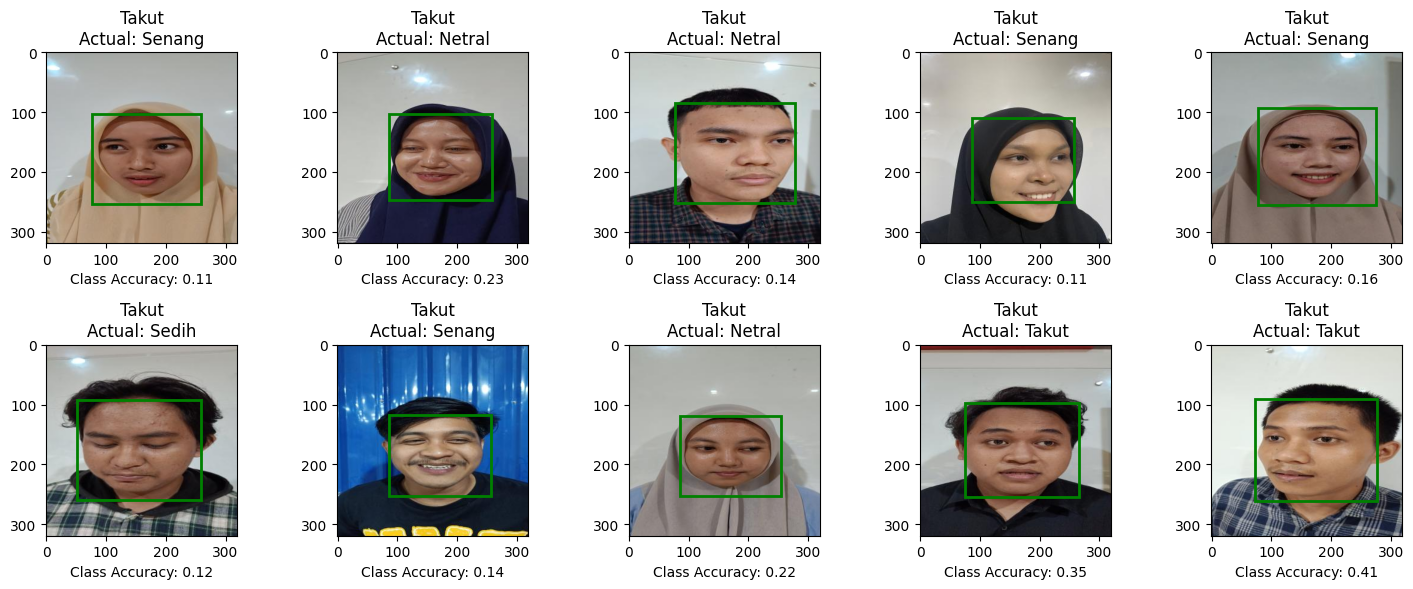

In [34]:
# Fungsi untuk menampilkan gambar dengan bounding box dan nilai prediksi
def display_validation_results(X_val, y_bbox_val, y_class_val, classes_list, model, num_samples=10, samples_per_row=5):
    predictions = model.predict(X_val)
    bbox_predictions, class_predictions = predictions[0], predictions[1]

    num_rows = (num_samples + samples_per_row - 1) // samples_per_row  # Menghitung jumlah baris yang diperlukan
    plt.figure(figsize=(15, 3 * num_rows))  # Menyesuaikan ukuran gambar berdasarkan jumlah baris

    for i in range(num_samples):
        image = X_val[i]
        bbox_pred = bbox_predictions[i]
        class_pred = np.argmax(class_predictions[i])

        plt.subplot(num_rows, samples_per_row, i + 1)
        plt.imshow(cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB))

        # Menggambar bounding box berdasarkan prediksi
        xmin, ymin, xmax, ymax = bbox_pred
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='green', facecolor='none', linewidth=2))
        plt.title(f'{classes_list[class_pred]}\nActual: {classes_list[y_class_val[i]]}')

        # Menambahkan nilai akurasi di subplot
        plt.xlabel(f'Class Accuracy: {class_predictions[i][y_class_val[i]]:.2f}')

        # Memastikan tidak ada subplot yang kosong di akhir baris terakhir
        if (i + 1) % samples_per_row == 0:
            plt.tight_layout()

    plt.tight_layout()
    plt.show()

# Panggil fungsi ini setelah Anda melatih model dan ingin menampilkan hasil validasi
display_validation_results(X_val, y_bbox_val, y_class_val, classes_list, model, num_samples=10, samples_per_row=5)


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi kelas pada data validasi
y_pred = model.predict(X_val)

# Mendapatkan kelas prediksi dengan nilai tertinggi
y_pred_class = np.argmax(y_pred[1], axis=1)

# Menampilkan confusion matrix
cm = confusion_matrix(y_class_val, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Menampilkan classification report
cr = classification_report(y_class_val, y_pred_class, target_names=classes_list)
print("Classification Report:")
print(cr)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step
Confusion Matrix:
[[ 3  1  7  1 27]
 [ 3  5  3  0 17]
 [ 2  3  6  0 19]
 [ 3  4  8  0 17]
 [ 1  3  3  0 24]]
Classification Report:
              precision    recall  f1-score   support

       Marah       0.25      0.08      0.12        39
      Netral       0.31      0.18      0.23        28
       Sedih       0.22      0.20      0.21        30
      Senang       0.00      0.00      0.00        32
       Takut       0.23      0.77      0.36        31

    accuracy                           0.24       160
   macro avg       0.20      0.25      0.18       160
weighted avg       0.20      0.24      0.18       160



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


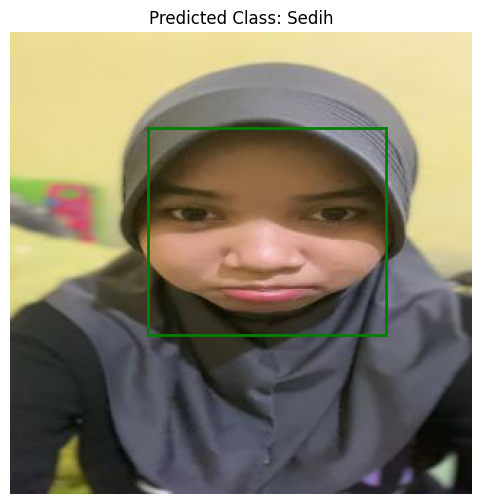

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan menampilkan gambar dengan prediksi bounding box
def validate_single_image(image_path, model, classes_list):
    # Periksa apakah path gambar ada
    if not os.path.exists(image_path):
        print(f"Error: Path gambar tidak ditemukan: {image_path}")
        return

    # Memuat gambar dari path
    image = cv2.imread(image_path)
    
    # Periksa apakah gambar berhasil dimuat
    if image is None:
        print(f"Error: Gambar tidak ditemukan atau tidak dapat dimuat dari path: {image_path}")
        return

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Konversi ke format RGB

    # Reshape gambar untuk model
    input_image = cv2.resize(image, (320, 320))  # Ubah sesuai dengan dimensi masukan model Anda
    input_image = np.expand_dims(input_image, axis=0)

    # Melakukan prediksi menggunakan model
    predictions = model.predict(input_image)
    bbox_predictions, class_predictions = predictions[0], predictions[1]

    # Mengambil hasil prediksi untuk gambar pertama
    bbox_pred = bbox_predictions[0]
    class_pred = np.argmax(class_predictions[0])

    # Menampilkan gambar dengan bounding box dan label prediksi
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)

    # Menggambar bounding box berdasarkan prediksi
    xmin, ymin, xmax, ymax = bbox_pred
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      edgecolor='green', facecolor='none', linewidth=2))
    plt.title(f'Predicted Class: {classes_list[class_pred]}')
    plt.axis('off')
    plt.show()

# Contoh penggunaan
# Ganti 'path_to_your_image.jpg' dengan path absolut dari gambar Anda
image_path = './arya4/images/IMG-20240622-WA0017_jpg.rf.49b4b48e157e44c493f43bdf729e0723.jpg'  # Ganti dengan path gambar Anda

# Verifikasi bahwa file tersebut ada di direktori saat ini
# print("Daftar file di direktori saat ini:", os.listdir('.'))

# Memanggil fungsi untuk memuat dan menampilkan gambar
validate_single_image(image_path, model, classes_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
class_pred: [0]
classes_list: ['Marah', 'Netral', 'Sedih', 'Senang', 'Takut']


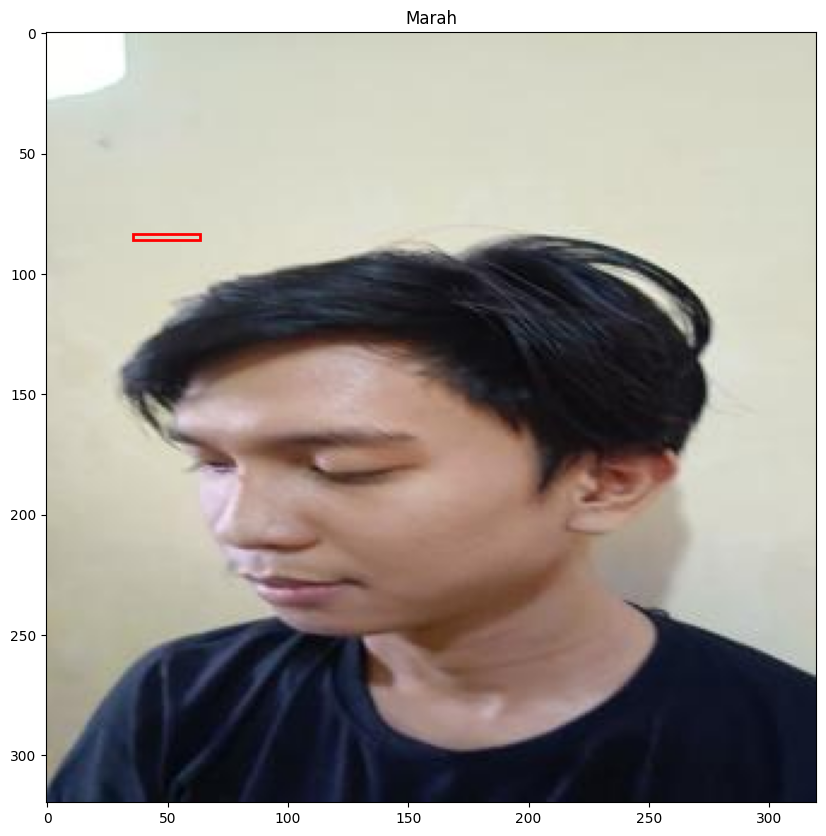

In [46]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import json

# Muat model yang telah dilatih
model_path = './checkpoints/model_checkpoint2.keras'  # Ganti dengan path lokal ke model Anda
model = load_model(model_path)

# Muat daftar kelas dari file JSON
classes_list_path = './data/classes_list.json'  # Ganti dengan path lokal ke file JSON Anda
with open(classes_list_path, 'r') as f:
    classes_list = json.load(f)

# Fungsi untuk memuat gambar uji
def load_test_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (320, 320))
    return image

# Fungsi untuk pra-pemrosesan gambar
def preprocess_image(image):
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Fungsi untuk membuat prediksi
def make_predictions(model, image):
    bbox_pred, class_pred = model.predict(image)
    class_pred = np.argmax(class_pred, axis=-1)
    return bbox_pred, class_pred

# Fungsi untuk menampilkan hasil
def display_test_image(image_path, bbox_pred, class_pred, classes_list):
    # Debugging: Periksa prediksi kelas dan daftar kelas
    print(f"class_pred: {class_pred}")
    print(f"classes_list: {classes_list}")

    if class_pred[0] < len(classes_list):
        label = classes_list[class_pred[0]]
    else:
        label = "Unknown"

    image = cv2.imread(image_path)
    image = cv2.resize(image, (320, 320))
    bbox = bbox_pred[0]

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                      edgecolor='red', facecolor='none', linewidth=2))
    plt.title(label)
    plt.show()

# Path ke gambar uji
test_image_path = './arya3/images/IMG20240611172129_jpg.rf.7dd7dfdc7a4129573d41b3497cc37765.jpg'  # Ganti dengan path lokal ke gambar uji Anda

# Muat dan pra-pemroses gambar uji
test_image = load_test_image(test_image_path)
preprocessed_image = preprocess_image(test_image)

# Buat prediksi
bbox_pred, class_pred = make_predictions(model, preprocessed_image)

# Tampilkan hasil
display_test_image(test_image_path, bbox_pred, class_pred, classes_list)

In [50]:
from tensorflow.keras.models import load_model

# Path ke model yang telah dilatih (.h5)
model_path = './checkpoints/model_checkpoint2.keras'
model = load_model(model_path)

In [52]:
from tensorflow.keras.models import load_model
import json

# Muat model yang telah dilatih
model_path = './checkpoints/model_checkpoint2.keras'  # Ganti dengan path lokal ke model Anda
model = load_model(model_path)

# Mendapatkan jumlah kelas dari model
# Ubah cara mendapatkan jumlah kelas dari lapisan Dense terakhir
num_classes = model.layers[-1].units  # 	•	model.layers[-1].units digunakan untuk mendapatkan jumlah unit (kelas) dari lapisan Dense terakhir.
print(f"Jumlah kelas dalam model: {num_classes}")

# Memastikan jumlah kelas sesuai dengan daftar kelas
classes_list_path = './data/classes_list.json'  # Ganti dengan path lokal ke file JSON Anda
with open(classes_list_path, 'r') as f:
    classes_list = json.load(f)

if num_classes == len(classes_list):
    print("Jumlah kelas dalam model sesuai dengan daftar kelas.")
else:
    print(f"Warning: Jumlah kelas dalam model ({num_classes}) tidak sesuai dengan daftar kelas ({len(classes_list)})")

Jumlah kelas dalam model: 5
Jumlah kelas dalam model sesuai dengan daftar kelas.


In [53]:
# Pastikan bahwa output layer adalah layer Dense dengan aktivasi softmax
output_layer = model.layers[-1]

# Ambil bobot (weights) dan bias dari output layer
weights, bias = output_layer.get_weights()

# Jika model menggunakan softmax untuk klasifikasi multikelas
if output_layer.activation == 'softmax':
    # Ambil daftar kelas dari bobot
    classes_list = list(output_layer.get_weights()[1])

# Cetak semua kelas yang ada dalam model
print("Kelas yang ada dalam model:")
for i, class_name in enumerate(classes_list):
    print(f"Kelas {i + 1}: {class_name}")


Kelas yang ada dalam model:
Kelas 1: Marah
Kelas 2: Netral
Kelas 3: Sedih
Kelas 4: Senang
Kelas 5: Takut
